In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from tueplots import bundles, fonts, fontsizes, figsizes

plt.rcParams.update(bundles.icml2024())
plt.rcParams.update(fonts.icml2024_tex())
plt.rcParams.update(fontsizes.icml2024())

os.environ['PATH'] += ':/usr/local/texlive/2024/bin/universal-darwin'
plt.rcParams['text.usetex'] = True

In [2]:
def plot_barscatter_ax(ax: plt.Axes, df: pd.DataFrame, title: str, ylabel: str):
    # Helper function for box-plots
    # adapted from https://cduvallet.github.io/posts/2018/03/boxplots-in-python

    hues = df['hue'].unique().tolist()

    sns.set_style('white')

    colors = [(0.6, 0.8, 1.0), (1.0, 0.8, 0.6), (0.6, 1.0, 0.8)]
    light_colors = colors

    pal = {key: value for key, value in zip(hues, colors[:len(hues)])}

    # Set up another palette for the boxplots, with slightly lighter shades
    face_pal = {key: value for key, value in zip(hues, light_colors[:len(hues)])}

    hue_order = hues

    # Make sure to remove the 'facecolor': 'w' property here, otherwise
    # the palette gets overrided
    boxprops = {'edgecolor': 'k', 'linewidth': 1}
    lineprops = {'color': 'k', 'linewidth': 1}

    boxplot_kwargs = {'boxprops': boxprops, 'medianprops': lineprops, 'whis': [10,90],
                      'whiskerprops': lineprops, 'capprops': lineprops,
                      'width': 0.75, 'palette': face_pal,
                      'hue_order': hue_order}

    stripplot_kwargs = {'linewidth': 0.4, 'size': 2.5, 'alpha': 1.0, 'palette': pal, 'hue_order': hue_order}

    ax.axhline(y=0, color='#888888', linestyle='--')
    ax.grid(True, which='major')

    sns.boxplot(x='label', y='value', hue='hue', data=df, ax=ax, fliersize=0, **boxplot_kwargs)
    sns.stripplot(x='label', y='value', hue='hue', data=df, ax=ax, dodge=True, jitter=0.18, **stripplot_kwargs)

    ax.set_yscale('symlog', linthresh=1)
    ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())
    ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.ticklabel_format(style='plain', axis='y')

    ax.set_ylabel(ylabel, fontsize='small')
    ax.set_xlabel('')
    ax.tick_params(axis='x', which='major', labelsize=6)
    ax.set_title(title, fontsize='small')
    ax.get_legend().remove()


def generate_logloss_df(dataset, model, n_seeds):
    # Helper function to extract best epoch logloss for different early stopping procedures

    columns = ['hue', 'label', 'value']
    df = pd.DataFrame(columns=columns)

    for seed in range(n_seeds):
        logs = pd.read_csv('./results_csv/'+dataset+'_'+model+'/benchmark_seed'+str(seed)+'.csv')

        best_epoch = logs['logloss/val'].idxmin() # best epoch for validation loss
        ref_loss = logs.loc[best_epoch]['logloss/test_ts'] # test loss after TS as a reference

        # Logging relative differences:
        df.loc[len(df)] = [model, 'Logloss', 100*(logs.loc[best_epoch]['logloss/test']/ref_loss-1)]
        df.loc[len(df)] = [model, 'Logloss+TS', 100*(logs.loc[best_epoch]['logloss/test_ts']/ref_loss-1)]

        best_epoch = logs['logloss/val_ts'].idxmin() # TS-refinement early stopping (validation loss after TS)
        df.loc[len(df)] = [model, 'TS-Ref.+TS', 100*(logs.loc[best_epoch]['logloss/test_ts']/ref_loss-1)]

        best_epoch = logs['error/val_error'].idxmin() # Validation accuracy early stopping
        df.loc[len(df)] = [model, 'Accuracy+TS', 100*(logs.loc[best_epoch]['logloss/test_ts']/ref_loss-1)]

    return df

In [12]:
# Score tables

model = 'wideresnet'
dataset = 'svhn'
n_seeds = 10

columns = ['Logloss', 'Brier', 'Accuracy', 'ECE', 'smECE']
rows = ['Logloss', 'Brier', 'Accuracy', 'TS-ref']

# Create a DataFrame filled with zeros
table = pd.DataFrame([[[] for _ in columns] for _ in rows], index=rows, columns=columns)

for seed in range(n_seeds):
    logs = pd.read_csv('./results_csv/'+dataset+'_'+model+'/benchmark_seed'+str(seed)+'.csv')

    for (name, key) in [('Logloss', 'logloss/val'), ('Brier', 'brier/val'), ('Accuracy', 'error/val_error'), ('TS-ref', 'logloss/val_ts')]:
        best_epoch = logs[key].idxmin()
        best_epoch_metrics = logs.loc[best_epoch]
        table.at[name, 'Accuracy'].append(100*(1-best_epoch_metrics['error/test_error']))
        table.at[name, 'Logloss'].append(best_epoch_metrics['logloss/test_ts'])
        table.at[name, 'Brier'].append(best_epoch_metrics['brier/test_ts'])
        table.at[name, 'ECE'].append(best_epoch_metrics['ece/test_ts'])
        table.at[name, 'smECE'].append(best_epoch_metrics['smece/test_ts'])

# Apply functions to compute mean and standard deviation for each cell
mean_df = table.map(lambda x: np.mean(x))
# Using t distribution quantile to build 95% CI since we have only 10 samples
std_df = table.map(lambda x: 2.262*np.std(x)/np.sqrt(n_seeds))

print("Mean DataFrame:")
print(mean_df.round(decimals=3))

print("\nStandard Error DataFrame:")
print(std_df.round(decimals=3))

Mean DataFrame:
          Logloss  Brier  Accuracy    ECE  smECE
Logloss     0.109  0.043    97.271  0.007  0.008
Brier       0.110  0.042    97.339  0.007  0.008
Accuracy    0.112  0.042    97.337  0.008  0.009
TS-ref      0.109  0.042    97.334  0.007  0.008

Standard Error DataFrame:
          Logloss  Brier  Accuracy    ECE  smECE
Logloss     0.002  0.001     0.061  0.001  0.001
Brier       0.003  0.001     0.045  0.001  0.001
Accuracy    0.002  0.001     0.055  0.001  0.001
TS-ref      0.001  0.000     0.042  0.001  0.001


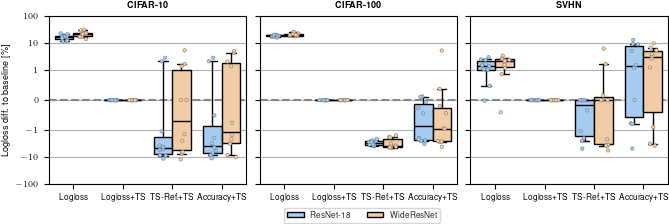

In [4]:
# Benchmark box-plots

n_seeds = 10

c10_r18 = generate_logloss_df('cifar10', 'resnet18', n_seeds)
c100_r18 = generate_logloss_df('cifar100', 'resnet18', n_seeds)
svhn_r18 = generate_logloss_df('svhn', 'resnet18', n_seeds)

c10_wrn = generate_logloss_df('cifar10', 'wideresnet', n_seeds)
c100_wrn = generate_logloss_df('cifar100', 'wideresnet', n_seeds)
svhn_wrn = generate_logloss_df('svhn', 'wideresnet', n_seeds)

plt.rcParams.update(figsizes.icml2024_full())

fig, axs = plt.subplots(1, 3, sharey='row')
plot_barscatter_ax(axs[0], pd.concat((c10_r18, c10_wrn)), title=r'\textbf{CIFAR-10}', ylabel=r'Logloss diff. to baseline [\%]')
plot_barscatter_ax(axs[1], pd.concat((c100_r18, c100_wrn)), title=r'\textbf{CIFAR-100}', ylabel=r'Logloss diff. to baseline [\%]')
plot_barscatter_ax(axs[2], pd.concat((svhn_r18, svhn_wrn)), title=r'\textbf{SVHN}', ylabel=r'Logloss diff. to baseline [\%]')

handles, labels = plt.gca().get_legend_handles_labels()
plt.figlegend(handles[:2], ('ResNet-18', 'WideResNet'), loc='lower center', bbox_to_anchor=(0.54, -.1), ncol=2)

plt.ylim(-100,100)

plt.savefig('figures/ComputerVisionBenchmark.pdf')
plt.show()

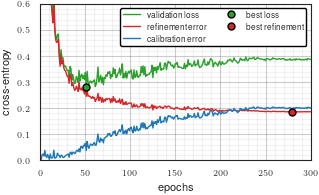

In [ ]:
# Paper Figure 1

df = pd.read_csv('./results_csv/cifar10_resnet18/cosine_no_wd_seed0.csv')

epoch = df.index.to_numpy()
loss = df['logloss/val'].to_numpy()
ref = df['logloss/val_ts'].to_numpy()
cal = df['logloss/val_gap'].to_numpy()

plt.rcParams.update(figsizes.icml2024_half())

plt.plot(epoch, loss, color='tab:green', label='validation loss', linewidth=1.0)
plt.plot(epoch, ref, color='tab:red', label='refinement error', linewidth=1.0)
plt.plot(epoch, cal, color='tab:blue', label='calibration error', linewidth=1.0)

best_epoch_loss = df['logloss/val'].idxmin()
plt.plot(epoch[best_epoch_loss], loss[best_epoch_loss],
         linestyle='None',
         marker='o', markersize=5, markerfacecolor='tab:green', markeredgecolor='black',
         label='best loss'
)

best_epoch_ref = df['logloss/val_ts'].idxmin()
plt.plot(epoch[best_epoch_ref], ref[best_epoch_ref],
         linestyle='None',
         marker='o', markersize=5, markerfacecolor='tab:red', markeredgecolor='black',
         label='best refinement'
)

plt.legend(ncol=2, loc='upper right', framealpha=1., edgecolor='0.')
plt.minorticks_on()
plt.grid(True, which='major', linestyle='-', color='gray', alpha=.4)
plt.grid(True, which='minor', linestyle='-', color='gray', alpha=.1)
plt.ylim((0., 0.6))
plt.xlim((0, 300))
plt.xlabel('epochs')
plt.ylabel('cross-entropy')
plt.savefig('figures/training_curve.pdf')
plt.show()